In [1]:
#MOTIF ANALYSIS USING INVIDIDUAL RT STOPS
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('bmh')
import os
from math import *
from subprocess import *
import pybedtools as pbt
from glob import glob
import seaborn as sns
import statsmodels.formula.api as sm
import csv
import re
from qcmodule import FrameKmer
csv.register_dialect("textdialect",delimiter='\t')
%matplotlib inline

/home/sam/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
plt.style.available

[u'seaborn-darkgrid',
 u'seaborn-notebook',
 u'classic',
 u'seaborn-ticks',
 u'grayscale',
 u'bmh',
 u'seaborn-talk',
 u'dark_background',
 u'ggplot',
 u'fivethirtyeight',
 u'seaborn-colorblind',
 u'seaborn-deep',
 u'seaborn-whitegrid',
 u'seaborn-bright',
 u'seaborn-poster',
 u'seaborn-muted',
 u'seaborn-paper',
 u'seaborn-white',
 u'seaborn-pastel',
 u'seaborn-dark',
 u'seaborn-dark-palette']

In [3]:
%%time

#The purpose of this is to perform motif analysis in each sample based on individual RT stops. I am going to do the simplest motif analysis with counting enriched kmers. Base this off of the Daminov et al., 2016 paper

#From the Damianov et al., 2016 paper
#The binding regions, defined as including 40 nucleotides upstream and 40 nucleotides downstream of each crosslinking site, were analyzed for enrichment of nucleotide pentamers. To control for nucleotide frequency biases, pentamer frequencies in the binding regions were compared to the distribution of pentamer frequencies in a large set of 81-nucleotide genomic intervals randomly chosen from the introns containing iCLIP clusters. GCAUG and UGCAU, the two pentamer derivatives of the UGCAUG motif, were the most enriched motifs in the binding regions (red dots, z-score > 645, Fig. S5). Several other near matches to the UGCAUG motif including CAUGU, GUAUG, UGUAU, GUGCA, CAUGC (orange dots, Fig. S5) were also highly enriched. Some of these partial matches were previously shown to bind Rbfox2 (Lambert et al., 2014).

#Generate the fasta files based on an extension interval

#File that contains the RT stops are labeled hnM_[DMSO/TAM]_RT_stops_sig. Import into pybedtools
dmso_rt_bt = pbt.BedTool('hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig')
tam_rt_bt = pbt.BedTool('hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_sig')

#slop in either direction and save
extension_interval = 15
dmso_rt_bt_extend = dmso_rt_bt.slop(b=extension_interval,genome='hg19')
dmso_rt_bt_extend.saveas('hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig_extension')
tam_rt_bt_extend = tam_rt_bt.slop(b=extension_interval,genome='hg19')
tam_rt_bt_extend.saveas('hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_sig_extension')

#generate fasta file
fasta = '/media/sam/Data1/annotations/hg19/hg19.fa'
dmso_rt_bt_extend_fasta = dmso_rt_bt_extend.sequence(fi=fasta,s=True)
dmso_rt_bt_extend_fasta.save_seqs('hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig_extension_fasta')
tam_rt_bt_extend_fasta = tam_rt_bt_extend.sequence(fi=fasta,s=True)
tam_rt_bt_extend_fasta.save_seqs('hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_sig_extension_fasta')

#Now we need suitable backgrounds. Use random intervals from the regions iCLIP clusters bind to. Since hnRNPM mostly binds to introns, use intersection intron
#NOTE - I AM NOT JUST USING THE INTRONIC RT STOPS BECAUSE IT SHOULD BE 95% OF THE TOTAL
#Consider just using the intronic RT stops
#Need to intersect with clusters with hg19_v19_introns from clipper regions
hg19_v19_introns_bt = pbt.BedTool('/home/sam/bin/clipper/clipper/data/regions/hg19_v19_introns.bed')
#Intersect with dmso
dmso_rt_bt_introns_intersect = hg19_v19_introns_bt.intersect(b=dmso_rt_bt,u=True,s=True)
dmso_rt_bt_introns_intersect.saveas('hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig_introns_intersect')
#Intersect with tam
tam_rt_bt_introns_intersect = hg19_v19_introns_bt.intersect(b=tam_rt_bt,u=True,s=True)
tam_rt_bt_introns_intersect.saveas('hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_sig_introns_intersect')

#Now that we have the introns, we need to select a large number of clusters of equal size to RT stop clusters.
#Use bedtools shuffle - but is it ok for me to use the same number of clusters but just shuffled. Or do I need more random samples?

#THIS CELL = 1 time shuffle - need to consider doing more than 1 shuffle

#DON'T USE PBT - IT FAILS FOR SOME REASON
!bedtools shuffle -i hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig_extension -g /home/sam/bin/ucsc_tools/hg19.chrom.sizes -incl hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig_introns_intersect -noOverlapping > hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig_introns_intersect_shuffle

!bedtools shuffle -i hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_sig_extension -g /home/sam/bin/ucsc_tools/hg19.chrom.sizes -incl hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_sig_introns_intersect -noOverlapping > hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_sig_introns_intersect_shuffle

#Get fasta
fasta = '/media/sam/Data1/annotations/hg19/hg19.fa'
dmso_rt_bt_introns_intersect_shuffle = pbt.BedTool('hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig_introns_intersect_shuffle')
dmso_rt_bt_introns_intersect_fasta = dmso_rt_bt_introns_intersect_shuffle.sequence(fi=fasta,s=True)
dmso_rt_bt_introns_intersect_fasta.save_seqs('hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig_introns_intersect_shuffle_fasta')

tam_rt_bt_introns_intersect_shuffle = pbt.BedTool('hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_sig_introns_intersect_shuffle')
tam_rt_bt_introns_intersect_fasta = tam_rt_bt_introns_intersect_shuffle.sequence(fi=fasta,s=True)
tam_rt_bt_introns_intersect_fasta.save_seqs('hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_sig_introns_intersect_shuffle_fasta')

CPU times: user 524 ms, sys: 320 ms, total: 844 ms
Wall time: 1min 33s


In [4]:
#Write a looper to generate n number of repeat shuffles of the things

CPU times: user 1min 46s, sys: 284 ms, total: 1min 47s
Wall time: 1min 48s


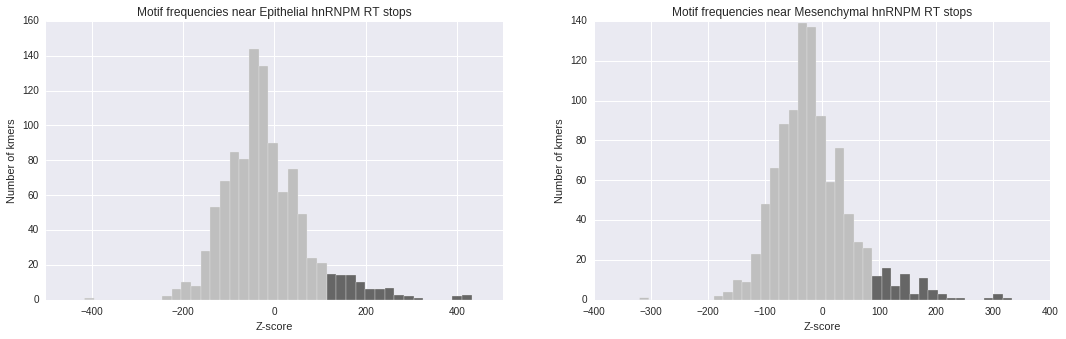

In [5]:
%%time

#Now calculate K-mer frequencies based on desired k-mer size and plot

#Choose K-mer size
kmer_size = 5

#Calculate Kmer frequencies
dmso_rt_freq = FrameKmer.kmer_freq_file(fastafile='hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig_extension_fasta',word_size=kmer_size)
tam_rt_freq = FrameKmer.kmer_freq_file(fastafile='hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_sig_extension_fasta',word_size=kmer_size)

#Now calculate the frequencies of each kmer so the total sums to 1
dmso_rt_freq_df = pd.DataFrame(dmso_rt_freq.items(),columns=['sequence','counts'])
dmso_sum = dmso_rt_freq_df.counts.astype('float').sum()
dmso_rt_freq_df['freq'] = dmso_rt_freq_df.apply(lambda row: float(row['counts'])/dmso_sum,axis=1)
dmso_rt_freq_df.sort_values('freq',ascending=False,inplace=True)

#Now calculate the frequencies of each kmer so the total sums to 1
tam_rt_freq_df = pd.DataFrame(tam_rt_freq.items(),columns=['sequence','counts'])
tam_sum = tam_rt_freq_df.counts.astype('float').sum()
tam_rt_freq_df['freq'] = tam_rt_freq_df.apply(lambda row: float(row['counts'])/tam_sum,axis=1)
tam_rt_freq_df.sort_values('freq',ascending=False,inplace=True)


#Calculate kmer frequencies of the introns
dmso_rt_intron_freq = FrameKmer.kmer_freq_file(fastafile='hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig_introns_intersect_shuffle_fasta',word_size=kmer_size)

tam_rt_intron_freq = FrameKmer.kmer_freq_file(fastafile='hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_sig_introns_intersect_shuffle_fasta',word_size=kmer_size)

#For the introns
#Now calculate the frequencies of each kmer so the total sums to 1
dmso_rt_intron_freq_df = pd.DataFrame(dmso_rt_intron_freq.items(),columns=['sequence','counts'])
dmso_intron_sum = dmso_rt_intron_freq_df.counts.astype('float').sum()
dmso_rt_intron_freq_df['freq'] = dmso_rt_intron_freq_df.apply(lambda row: float(row['counts'])/dmso_intron_sum,axis=1)
dmso_rt_intron_freq_df.sort_values('freq',ascending=False,inplace=True)

#Now calculate the frequencies of each kmer so the total sums to 1
tam_rt_intron_freq_df = pd.DataFrame(tam_rt_intron_freq.items(),columns=['sequence','counts'])
tam_intron_sum = tam_rt_intron_freq_df.counts.astype('float').sum()
tam_rt_intron_freq_df['freq'] = tam_rt_intron_freq_df.apply(lambda row: float(row['counts'])/tam_intron_sum,axis=1)
tam_rt_intron_freq_df.sort_values('freq',ascending=False,inplace=True)

#Now that I have all of the frequencies for the kmers, I need to calculate the z-score for each kmers
#The TWO PROPORTION Z TEST http://www.statisticshowto.com/z-test/
#Z = (freq1 - freq2) - 0 / sqrt(p(1-p)(1/counts1+1/counts2))
#p = (counts1+counts2)/(sum1+sum2)

#save each of the frequency files as CSVs
dmso_rt_freq_df.to_csv('motif_analysis/hnM_DMSO_RT_kmer_frequencies',sep='\t',index=False)
dmso_rt_intron_freq_df.to_csv('motif_analysis/hnM_DMSO_RT_intron_shuffle_kmer_frequencies',sep='\t',index=False)
tam_rt_freq_df.to_csv('motif_analysis/hnM_TAM_RT_kmer_frequencies',sep='\t',index=False)
tam_rt_intron_freq_df.to_csv('motif_analysis/hnM_TAM_RT_intron_shuffle_kmer_frequencies',sep='\t',index=False)

#Read them back in as dataframes
dmso_rt_freq_df = pd.read_csv('motif_analysis/hnM_DMSO_RT_kmer_frequencies',sep='\t')
dmso_rt_intron_freq_df = pd.read_csv('motif_analysis/hnM_DMSO_RT_intron_shuffle_kmer_frequencies',sep='\t')
tam_rt_freq_df = pd.read_csv('motif_analysis/hnM_TAM_RT_kmer_frequencies',sep='\t')
tam_rt_intron_freq_df = pd.read_csv('motif_analysis/hnM_TAM_RT_intron_shuffle_kmer_frequencies',sep='\t')

#Merge the dataframes with clipper on the left, introns on the right
#X = RT stops
#Y = Random intervals

dmso_rt_combined_freq = pd.merge(dmso_rt_freq_df,dmso_rt_intron_freq_df,on='sequence')
tam_rt_combined_freq = pd.merge(tam_rt_freq_df,tam_rt_intron_freq_df,on='sequence')

#Now calculate the sum of frequencies of sample and control
#Also calculate the sum of all the kmer
def freq_x_plus_y(row):
    freq_sum = row['freq_x']+row['freq_y']
    return freq_sum
dmso_x_sum = dmso_rt_combined_freq.counts_x.astype('float').sum()
dmso_y_sum = dmso_rt_combined_freq.counts_y.astype('float').sum()

tam_x_sum = tam_rt_combined_freq.counts_x.astype('float').sum()
tam_y_sum = tam_rt_combined_freq.counts_y.astype('float').sum()

#Now write a function to calculate the Z score for each things
def frequency_z_score_dmso(row):
    p = (float(row['counts_x']+row['counts_y'])) / (dmso_x_sum + dmso_y_sum)
    z = (row['freq_x'] - row['freq_y']) / np.sqrt((p*(1-p)*((1/dmso_x_sum)+(1/dmso_y_sum))))
    return z
    
def frequency_z_score_tam(row):
    p = (float(row['counts_x']+row['counts_y'])) / (tam_x_sum + tam_y_sum)
    z = (row['freq_x'] - row['freq_y']) / np.sqrt((p*(1-p)*((1/tam_x_sum)+(1/tam_y_sum))))
    return z

#calculate the z scores
dmso_rt_combined_freq['z_score'] = dmso_rt_combined_freq.apply(frequency_z_score_dmso,axis=1)
tam_rt_combined_freq['z_score'] = tam_rt_combined_freq.apply(frequency_z_score_tam,axis=1)

#Sort the dataframes
dmso_rt_combined_freq.sort_values('z_score',ascending=False,inplace=True)
tam_rt_combined_freq.sort_values('z_score',ascending=False,inplace=True)

#Save the tables of kmer with associated Z score
dmso_rt_combined_freq.sort_values('z_score',ascending=False).to_csv('motif_analysis/hnM_DMSO_kmer_z_score',sep='\t',index=False)
tam_rt_combined_freq.sort_values('z_score',ascending=False).to_csv('motif_analysis/hnM_TAM_kmer_z_score',sep='\t',index=False)

#Now plot a histogram highlighting the Z-scores in bins
#Consider shading top 10% of z scores
freq_hist, (dmso,tam) = plt.subplots(1,2,figsize=(18,5))
#This allows you to collect information about the histogram
counts, bins, patches = dmso.hist(dmso_rt_combined_freq.z_score,bins=40,color='0.75')
dmso.set_title('Motif frequencies near Epithelial hnRNPM RT stops')
dmso.set_xlabel('Z-score')
dmso.set_ylabel('Number of kmers')
# Change the colors of bars at the edges...
ninetieth = np.percentile(dmso_rt_combined_freq.z_score,90)
for patch, sigside in zip(patches, bins):
    if sigside > ninetieth:
        patch.set_facecolor('0.4')


counts, bins, patches = tam.hist(tam_rt_combined_freq.z_score,bins=40,color='0.75')
tam.set_title('Motif frequencies near Mesenchymal hnRNPM RT stops')
tam.set_xlabel('Z-score')
tam.set_ylabel('Number of kmers')
# Change the colors of bars at the edges...
ninetieth = np.percentile(tam_rt_combined_freq.z_score,90)
for patch, sigside in zip(patches, bins):
    if sigside > ninetieth:
        patch.set_facecolor('0.4')

freq_hist.savefig('motif_analysis/epi_and_mes_kmer_z-score_histograms',format='png',dpi=300)

/home/sam/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


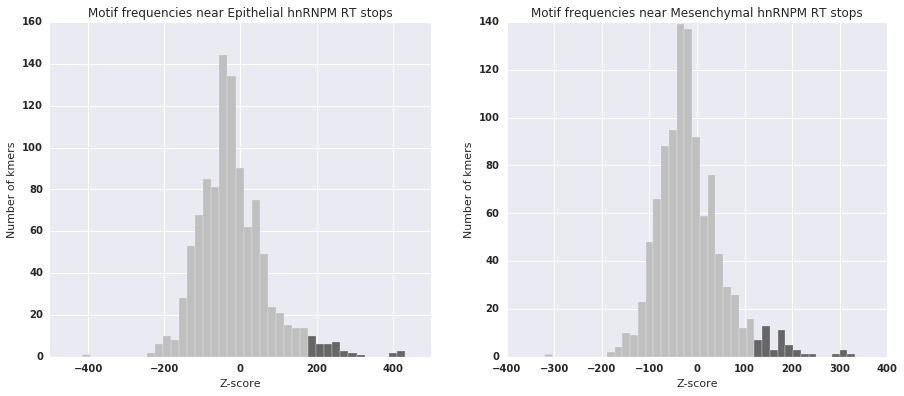

In [6]:
#Now plot a histogram highlighting the Z-scores in bins

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 25}

plt.rc('font', **font)

freq_hist, (dmso,tam) = plt.subplots(1,2,figsize=(15,6))

#This allows you to collect information about the histogram
counts, bins, patches = dmso.hist(dmso_rt_combined_freq.z_score,bins=40,color='0.75')
dmso.set_title('Motif frequencies near Epithelial hnRNPM RT stops')
dmso.set_xlabel('Z-score')
dmso.set_ylabel('Number of kmers')
# Change the colors of bars at the edges...
ninetieth = np.percentile(dmso_rt_combined_freq.z_score,95)
for patch, sigside in zip(patches, bins):
    if sigside > ninetieth:
        patch.set_facecolor('0.4')


counts, bins, patches = tam.hist(tam_rt_combined_freq.z_score,bins=40,color='0.75')
tam.set_title('Motif frequencies near Mesenchymal hnRNPM RT stops')
tam.set_xlabel('Z-score')
tam.set_ylabel('Number of kmers')
# Change the colors of bars at the edges...
ninetieth = np.percentile(tam_rt_combined_freq.z_score,95)
for patch, sigside in zip(patches, bins):
    if sigside > ninetieth:
        patch.set_facecolor('0.4')

freq_hist.savefig('motif_analysis/epi_and_mes_kmer_z-score_histograms',format='png',dpi=300)

In [19]:
#Collect a list of all of the GU rich pentamers specified in the Black paper
#Rules - G and T only. No more than 2 Gs or 2 Us next to each other. No more than 3 Us or Gs total
#These are from the Damianov et al., 2016 paper

hnM_pentamers = ['TGTGT','GTGTG','TTGTG','GTGTT','TGTTG','TGTGG','GTTGT','GGTGT','TGGTT','TTGGT','TGGTG','GTGGT','GTTGG','GGTTG']

Rbfox_pentamers = ['GCATG','TGCAT','CATGU','GTATG','TGTAT','GTGCA','CATGC']

hnRNP_C_pentamers = ['TTTTG','GTTTT','TTTTT','ATTTT','TTTTA','TTTTC','CTTTT']

hnRNP_H_pentamers = ['GGGGT','CGGGG','GGGGG','TGGGG','GGGGC','GGGGA','AGGGG']

ESRP1_pentamers = ['GTGGG','GGTGG','GGGGT','TGGGG','TGGTG','GTGGT','GGGGG','TGTGG','GTGTG','GGTGT']

#How can you select colums that pertain to something in a series... sue isin!
#Make sure to set a y value using the following key:
#hnM = 1
#Rbfox = 2
#hnRNP_C = 3
#hnRNP_H = 4

dmso_hnM = dmso_rt_combined_freq.loc[dmso_rt_combined_freq['sequence'].isin(hnM_pentamers)]
dmso_hnM['RBP'] = 1
dmso_hnM['RBP_name'] = 'hnRNPM'

dmso_Rbfox = dmso_rt_combined_freq.loc[dmso_rt_combined_freq['sequence'].isin(Rbfox_pentamers)]
dmso_Rbfox['RBP'] = 2
dmso_Rbfox['RBP_name'] = 'Rbfox'

dmso_hnC = dmso_rt_combined_freq.loc[dmso_rt_combined_freq['sequence'].isin(hnRNP_C_pentamers)]
dmso_hnC['RBP'] = 3
dmso_hnC['RBP_name'] = 'hnRNPC'

dmso_hnH = dmso_rt_combined_freq.loc[dmso_rt_combined_freq['sequence'].isin(hnRNP_H_pentamers)]
dmso_hnH['RBP'] = 4
dmso_hnH['RBP_name'] = 'hnRNPH'

dmso_ESRP1 = dmso_rt_combined_freq.loc[dmso_rt_combined_freq['sequence'].isin(ESRP1_pentamers)]
dmso_ESRP1['RBP'] = 5
dmso_ESRP1['RBP_name'] = 'ESRP1'

tam_hnM = tam_rt_combined_freq.loc[tam_rt_combined_freq['sequence'].isin(hnM_pentamers)]
tam_hnM['RBP'] = 1
tam_hnM['RBP_name'] = 'hnRNPM'

tam_Rbfox = tam_rt_combined_freq.loc[tam_rt_combined_freq['sequence'].isin(Rbfox_pentamers)]
tam_Rbfox['RBP'] = 2
tam_Rbfox['RBP_name'] = 'Rbfox'

tam_hnC = tam_rt_combined_freq.loc[tam_rt_combined_freq['sequence'].isin(hnRNP_C_pentamers)]
tam_hnC['RBP'] = 3
tam_hnC['RBP_name'] = 'hnRNPC'

tam_hnH = tam_rt_combined_freq.loc[tam_rt_combined_freq['sequence'].isin(hnRNP_H_pentamers)]
tam_hnH['RBP'] = 4
tam_hnH['RBP_name'] = 'hnRNPH'

tam_ESRP1 = tam_rt_combined_freq.loc[tam_rt_combined_freq['sequence'].isin(ESRP1_pentamers)]
tam_ESRP1['RBP'] = 5
tam_ESRP1['RBP_name'] = 'ESRP1'

#concat together

dmso_concat = pd.concat([dmso_hnM,dmso_Rbfox,dmso_hnC,dmso_hnH],ignore_index=True)
tam_concat = pd.concat([tam_hnM,tam_Rbfox,tam_hnC,tam_hnH],ignore_index=True)

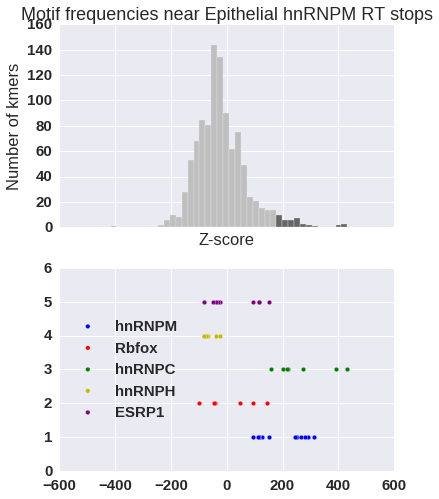

In [26]:
sns.set(font_scale=1.5)
#DMSO
#How can I plot colorful dots corresponding to specific kmers under the plot
#How to get this to work --> very difficult to use a line

#Now plot a histogram highlighting the Z-scores in bins
#Consider shading top 10% of z scores
freq_hist, (dmso,dmso_line) = plt.subplots(2,1,figsize=(6,8),sharex=True,facecolor='white')
#This allows you to collect information about the histogram
counts, bins, patches = dmso.hist(dmso_rt_combined_freq.z_score,bins=40,color='0.75')
dmso.set_title('Motif frequencies near Epithelial hnRNPM RT stops')
dmso.set_xlabel('Z-score')
dmso.set_ylabel('Number of kmers')
# Change the colors of bars at the edges...
ninetieth = np.percentile(dmso_rt_combined_freq.z_score,95)
for patch, sigside in zip(patches, bins):
    if sigside > ninetieth:
        patch.set_facecolor('0.4')

#This does not work well - I can't get any of the features to plot        
dmso_line.scatter(dmso_hnM.z_score, dmso_hnM.RBP,marker='o',c='b',label = 'hnRNPM')
dmso_line.scatter(dmso_Rbfox.z_score, dmso_Rbfox.RBP,marker='o',c='r',label = 'Rbfox')
dmso_line.scatter(dmso_hnC.z_score, dmso_hnC.RBP,marker='o',c='g',label = 'hnRNPC')
dmso_line.scatter(dmso_hnH.z_score, dmso_hnH.RBP,marker='o',c='y',label = 'hnRNPH')
dmso_line.scatter(dmso_ESRP1.z_score, dmso_ESRP1.RBP,marker='o',c='purple',label = 'ESRP1')


dmso_line.set_xlabel = 'Z-score'
dmso_line.set_ybound(lower=0,upper=6)
dmso_line.legend(loc='center left')

freq_hist.savefig('motif_analysis/epi_and_damianov_motifs',format='png',dpi=300)

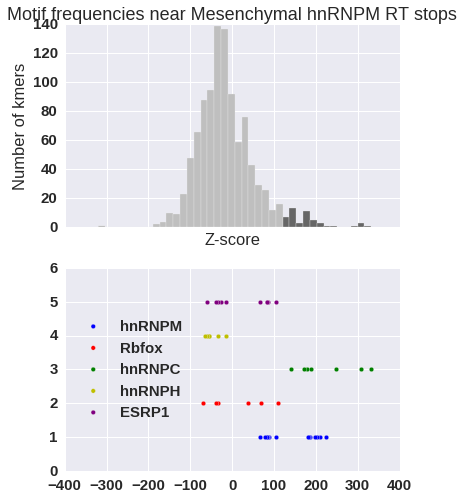

In [27]:
#TAM
#How can I plot colorful dots corresponding to specific kmers under the plot
#How to get this to work --> very difficult to use a line

#Now plot a histogram highlighting the Z-scores in bins
#Consider shading top 10% of z scores
freq_hist, (tam,tam_line) = plt.subplots(2,1,figsize=(6,8),sharex=True,facecolor='white')
#This allows you to collect information about the histogram
counts, bins, patches = tam.hist(tam_rt_combined_freq.z_score,bins=40,color='0.75')
tam.set_title('Motif frequencies near Mesenchymal hnRNPM RT stops')
tam.set_xlabel('Z-score')
tam.set_ylabel('Number of kmers')
# Change the colors of bars at the edges...
ninetieth = np.percentile(tam_rt_combined_freq.z_score,95)
for patch, sigside in zip(patches, bins):
    if sigside > ninetieth:
        patch.set_facecolor('0.4')

#This does not work well - I can't get any of the features to plot        
tam_line.scatter(tam_hnM.z_score, tam_hnM.RBP,marker='o',c='b',label = 'hnRNPM')
tam_line.scatter(tam_Rbfox.z_score, tam_Rbfox.RBP,marker='o',c='r',label = 'Rbfox')
tam_line.scatter(tam_hnC.z_score, tam_hnC.RBP,marker='o',c='g',label = 'hnRNPC')
tam_line.scatter(tam_hnH.z_score, tam_hnH.RBP,marker='o',c='y',label = 'hnRNPH')
tam_line.scatter(tam_ESRP1.z_score, tam_ESRP1.RBP,marker='o',c='purple',label = 'ESRP1')

tam_line.set_xlabel = 'Z-score'
tam_line.set_ybound(lower=0,upper=6)
tam_line.legend(loc='center left')

freq_hist.savefig('motif_analysis/mes_and_damianov_motifs',format='png',dpi=300)

In [16]:
#Collect a list of all of the GU rich pentamers specified in the Black paper
#Rules - G and T only. No more than 2 Gs or 2 Us next to each other. No more than 3 Us or Gs total
#These are from the black paper
hnM_pentamers = ['TGTGT','GTGTG','TTGTG','GTGTT','TGTTG','TGTGG','GTTGT','GGTGT','TGGTT','TTGGT','TGGTG','GTGGT','GTTGG','GGTTG']
hnM_pentamers_df = pd.Series(hnM_pentamers,name='sequence')

#How can you select colums that pertain to something in a series... use isin!
dmso_rt_combined_freq_black_pentamers = dmso_rt_combined_freq.loc[dmso_rt_combined_freq['sequence'].isin(hnM_pentamers_df)]


In [11]:
#reorganize the clipper_sig_extension so that it has a unique ID in column 4
with open('hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig_extension') as f:
    outlist = []
    counter = 1
    for line in f:
        line = line.strip().split('\t')
        line[3] = counter
        outlist.append(line)
        counter += 1
        
with open('hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig_extension_with_id','w') as f:
    writer = csv.writer(f,'textdialect')
    writer.writerows(outlist)

In [12]:
#### ANALYIS WITH MEME ####

In [13]:
#Try the meme analysis - but limit to only the top binding sites
#We want to make sure we have normalized the binding based on gene expression though
#bring in the master dataframe from the individual RT stops analysis
master_df = pd.read_csv('hnM_DMSO_TAM_master_dataframe_gene_expression_normalized_1nt',sep='\t')

In [14]:
dmso_master.head()

NameError: name 'dmso_master' is not defined

In [ ]:
#Try meme analysis alone - see what kind of motifs you can find
#Let's try just chaolin's method from his paper - THEY DID +/- 10
#Use the top 1000 sequences
#control the gene expression cutoff
fpkm_cutoff = 1
dmso_master = master_df[master_df.twist_d0_fpkm >= fpkm_cutoff]
#control the biotype - turn this off if you don't care
biotype = ''
biotype = 'protein_coding'
dmso_master = dmso_master[dmso_master.biotype == biotype]
#sort and take the top 5000 based on gene_expression_normalized_binding_intensity. No need to be normalized based on length because these are individual RT stops
top_cutoff = 1000
dmso_master.sort_values(by='hnM_DMSO_clip_gene_fpkm_norm',ascending=False,inplace=True)
dmso_master.reset_index(drop=True,inplace=True)
dmso_top = dmso_master[:top_cutoff]
#Export just the part of this for a bed file
bed_cols = ['chrom','start','end','ens_gene','hnM_DMSO_clip_gene_fpkm_norm','strand']
dmso_top_bed = dmso_top[bed_cols]
#now turn into a bedtools 
dmso_top_bed_bedtool = pbt.BedTool.from_dataframe(dmso_top_bed)
#slop by desired extension
extension = 10
dmso_top_bed_bedtool_extend = dmso_top_bed_bedtool.slop(b=extension,genome='hg19')
dmso_top_bed_bedtool_extend.saveas('motif_analysis/meme/dmso_rt_top_extension')
#Get fasta
fasta = '/media/sam/Data1/annotations/hg19/hg19.fa'
dmso_top_bed_bedtool_extend_fasta = dmso_top_bed_bedtool_extend.sequence(fi=fasta,s=True)
dmso_top_bed_bedtool_extend_fasta.save_seqs('motif_analysis/meme/dmso_rt_top_extension_fasta')

#!meme motif_analysis/meme/dmso_rt_top_extension_fasta -mod zoops -nmotifs 10 -minw 6 -maxw 8 -oc motif_analysis/meme/dmso_meme_only_10_flank_zoops_6_8 -p 8

In [ ]:
#This is just to get the proper sequences
#control the gene expression cutoff
fpkm_cutoff = 1
dmso_master = master_df[master_df.twist_d0_fpkm >= fpkm_cutoff]
#control the biotype - turn this off if you don't care
biotype = ''
biotype = 'protein_coding'
# dmso_master = dmso_master[dmso_master.biotype == biotype]
#sort and take the top 5000 based on gene_expression_normalized_binding_intensity. No need to be normalized based on length because these are individual RT stops
top_cutoff = 5000
dmso_master.sort_values(by='hnM_DMSO_clip_gene_fpkm_norm',ascending=False,inplace=True)
dmso_master.reset_index(drop=True,inplace=True)
dmso_top = dmso_master[:top_cutoff]
#Export just the part of this for a bed file
bed_cols = ['chrom','start','end','ens_gene','hnM_DMSO_clip_gene_fpkm_norm','strand']
dmso_top_bed = dmso_top[bed_cols]
#now turn into a bedtools 
dmso_top_bed_bedtool = pbt.BedTool.from_dataframe(dmso_top_bed)
#slop by desired extension
extension = 50
dmso_top_bed_bedtool_extend = dmso_top_bed_bedtool.slop(b=extension,genome='hg19')
dmso_top_bed_bedtool_extend.saveas('motif_analysis/meme/dmso_rt_top_extension')
#Get fasta
fasta = '/media/sam/Data1/annotations/hg19/hg19.fa'
dmso_top_bed_bedtool_extend_fasta = dmso_top_bed_bedtool_extend.sequence(fi=fasta,s=True)
dmso_top_bed_bedtool_extend_fasta.save_seqs('motif_analysis/meme/dmso_rt_top_extension_fasta')
#now get the background set by intersecting with introns
hg19_v19_introns_bt = pbt.BedTool('/home/sam/bin/clipper/clipper/data/regions/hg19_v19_introns.bed')
#Intersect with dmso
dmso_introns_intersect = hg19_v19_introns_bt.intersect(b=dmso_top_bed_bedtool,u=True,s=True)
#shuffle_the_introns and save the file
intron_shuffle = dmso_top_bed_bedtool_extend.shuffle(genome='hg19',incl=dmso_introns_intersect.fn,noOverlapping=True)
intron_shuffle.saveas('motif_analysis/meme/dmso_rt_top_extension_intron_shuffle')
#Get shuffle fasta
intron_shuffle_fasta = intron_shuffle.sequence(fi=fasta,s=True)
intron_shuffle_fasta.save_seqs('motif_analysis/meme/dmso_rt_top_extension_intron_shuffle_fasta')

In [ ]:
#DMSO - meme_chip
#control the gene expression cutoff
fpkm_cutoff = 1
dmso_master = master_df[master_df.twist_d0_fpkm >= fpkm_cutoff]
#control the biotype - turn this off if you don't care
biotype = ''
# biotype = 'protein_coding'
# dmso_master = dmso_master[dmso_master.biotype == biotype]
#sort and take the top 5000 based on gene_expression_normalized_binding_intensity. No need to be normalized based on length because these are individual RT stops
top_cutoff = 5000
dmso_master.sort_values(by='hnM_DMSO_clip_gene_fpkm_norm',ascending=False,inplace=True)
dmso_master.reset_index(drop=True,inplace=True)
dmso_top = dmso_master[:top_cutoff]
#Export just the part of this for a bed file
bed_cols = ['chrom','start','end','ens_gene','hnM_DMSO_clip_gene_fpkm_norm','strand']
dmso_top_bed = dmso_top[bed_cols]
#now turn into a bedtools 
dmso_top_bed_bedtool = pbt.BedTool.from_dataframe(dmso_top_bed)
#slop by desired extension
extension = 50
dmso_top_bed_bedtool_extend = dmso_top_bed_bedtool.slop(b=extension,genome='hg19')
dmso_top_bed_bedtool_extend.saveas('motif_analysis/meme/dmso_rt_top_extension')
#Get fasta
fasta = '/media/sam/Data1/annotations/hg19/hg19.fa'
dmso_top_bed_bedtool_extend_fasta = dmso_top_bed_bedtool_extend.sequence(fi=fasta,s=True)
dmso_top_bed_bedtool_extend_fasta.save_seqs('motif_analysis/meme/dmso_rt_top_extension_fasta')
#now get the background set by intersecting with introns
hg19_v19_introns_bt = pbt.BedTool('/home/sam/bin/clipper/clipper/data/regions/hg19_v19_introns.bed')
#Intersect with dmso
dmso_introns_intersect = hg19_v19_introns_bt.intersect(b=dmso_top_bed_bedtool,u=True,s=True)
#shuffle_the_introns and save the file
intron_shuffle = dmso_top_bed_bedtool_extend.shuffle(genome='hg19',incl=dmso_introns_intersect.fn,noOverlapping=True)
intron_shuffle.saveas('motif_analysis/meme/dmso_rt_top_extension_intron_shuffle')
#Get shuffle fasta
intron_shuffle_fasta = intron_shuffle.sequence(fi=fasta,s=True)
intron_shuffle_fasta.save_seqs('motif_analysis/meme/dmso_rt_top_extension_intron_shuffle_fasta')
#now try running meme-chip
#consider running with -meme-mod anr because we have no idea how many motis may exist
#There is also the other model oops to consider
meme_mod = 'zoops'
motif_db = '/home/sam/meme/db/motif_databases/RNA/Ray2013_rbp_Homo_sapiens.dna_encoded.meme'
cmd = 'meme-chip motif_analysis/meme/dmso_rt_top_extension_fasta -neg motif_analysis/meme/dmso_rt_top_extension_intron_shuffle_fasta -meme-minw 5 -meme-maxw 10 -norc -meme-p 8 -meme-mod {} -nmeme 1000 -db {} -centrimo-local -norand -oc motif_analysis/meme/dmso_meme_chip_from_motif_analysis_top{}_{}_{}_{}_{}_centrimo_local'.format(meme_mod,motif_db,str(top_cutoff),str(extension)+'bp_extension',biotype,'fpkm_'+str(fpkm_cutoff),meme_mod)
os.system(cmd)

In [ ]:
#TAM - meme_chip
#control the gene expression cutoff
fpkm_cutoff = 1
tam_master = master_df[master_df.twist_d14_fpkm >= fpkm_cutoff]
#control the biotype - turn this off if you don't care
biotype = ''
biotype = 'protein_coding'
tam_master = tam_master[tam_master.biotype == biotype]
#sort and take the top 5000 based on gene_expression_normalized_binding_intensity. No need to normalized based on length because these are individual RT stops
top_cutoff = 5000
tam_master.sort_values(by='hnM_TAM_clip_gene_fpkm_norm',ascending=False,inplace=True)
tam_master.reset_index(drop=True,inplace=True)
tam_top = tam_master[:top_cutoff]
#Export just the part of this for a bed file
bed_cols = ['chrom','start','end','ens_gene','hnM_TAM_clip_gene_fpkm_norm','strand']
tam_top_bed = tam_top[bed_cols]
#now turn into a bedtools 
tam_top_bed_bedtool = pbt.BedTool.from_dataframe(tam_top_bed)
#slop by desired extension
extension = 50
tam_top_bed_bedtool_extend = tam_top_bed_bedtool.slop(b=extension,genome='hg19')
tam_top_bed_bedtool_extend.saveas('motif_analysis/meme/tam_rt_top_extension')
#Get fasta
fasta = '/media/sam/Data1/annotations/hg19/hg19.fa'
tam_top_bed_bedtool_extend_fasta = tam_top_bed_bedtool_extend.sequence(fi=fasta,s=True)
tam_top_bed_bedtool_extend_fasta.save_seqs('motif_analysis/meme/tam_rt_top_extension_fasta')
#now get the background set by intersecting with introns
hg19_v19_introns_bt = pbt.BedTool('/home/sam/bin/clipper/clipper/data/regions/hg19_v19_introns.bed')
#Intersect with tam
tam_introns_intersect = hg19_v19_introns_bt.intersect(b=tam_top_bed_bedtool,u=True,s=True)
#shuffle_the_introns and save
intron_shuffle = tam_top_bed_bedtool_extend.shuffle(genome='hg19',incl=tam_introns_intersect.fn,noOverlapping=True)
intron_shuffle.saveas('motif_analysis/meme/tam_rt_top_extension_intron_shuffle')
#Get shuffle fasta
intron_shuffle_fasta = intron_shuffle.sequence(fi=fasta,s=True)
intron_shuffle_fasta.save_seqs('motif_analysis/meme/tam_rt_top_extension_intron_shuffle_fasta')
#now try running meme-chip
meme_mod = 'zoops'
motif_db = '/home/sam/meme/db/motif_databases/RNA/Ray2013_rbp_Homo_sapiens.dna_encoded.meme'
cmd = 'meme-chip motif_analysis/meme/tam_rt_top_extension_fasta -neg motif_analysis/meme/tam_rt_top_extension_intron_shuffle_fasta -meme-minw 5 -meme-maxw 10 -norc -meme-p 8 -meme-mod {} -nmeme 1000 -db {} -centrimo-local -norand -oc motif_analysis/meme/tam_meme_chip_from_motif_analysis_top{}_{}_{}_{}_{}_centrimo_local'.format(meme_mod,motif_db,str(top_cutoff),str(extension)+'bp_extension',biotype,'fpkm_'+str(fpkm_cutoff),meme_mod)
os.system(cmd)

In [ ]:
tam_master.describe()

In [ ]:
#ANALYSIS WITH HOMER

In [ ]:
#trying to get homer to work using the same input as meme
#This is using the top 5000
#DMSO
!findMotifsGenome.pl motif_analysis/meme/dmso_rt_top_extension hg19 motif_analysis/homer/dmso_homer_results_top_5000_protein_coding -size given -rna -len 4,6,8,10 -basic -bg motif_analysis/meme/dmso_rt_top_extension_intron_shuffle

#TAM
!findMotifsGenome.pl motif_analysis/meme/tam_rt_top_extension hg19 motif_analysis/homer/tam_homer_results_top_5000_protein_coding -size given -rna -len 4,6,8,10 -basic -bg motif_analysis/meme/tam_rt_top_extension_intron_shuffle

In [ ]:
#####
#read things
